In [1]:
import json
import random
import allennlp
import numpy as np
import torch
import logging
import collections
import bert.tokenization as tokenization
from bert.modeling_drop import MTMSN
from bert.optimization import BERTAdam
from drop.drop_utils import DropReader, convert_examples_to_features, get_tensors, get_tensors_list, write_predictions, \
    ClusteredBatcher, FixedOrderBatcher, FeatureLenKey, batch_annotate_candidates, wrapped_get_final_text
from drop.drop_metric import DropEmAndF1
from bert.run_mtmsn import evaluate
from squad.squad_evaluate import f1_score as calculate_f1
from squad.squad_utils import _get_best_indexes, get_final_text, _compute_softmax
from decimal import Decimal

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


# collect wrongly predicted answers for error analysis

In [ ]:
logger = logging.getLogger(__name__)

In [ ]:
sign_remap = {0: 0, 1: 1, 2: -1}

In [ ]:
from bert.modeling import BertConfig
bert_config = BertConfig.from_json_file('18/bert_config.json')

In [ ]:
model = MTMSN(bert_config)
tokenizer = tokenization.FullTokenizer(
        vocab_file='18/vocab.txt', do_lower_case=True)

In [ ]:
checkpoint = torch.load('18/checkpoint.pth.tar',map_location=torch.device('cpu'))

In [ ]:
from collections import OrderedDict
model_cp = []
for i in checkpoint['model']:
    model_cp.append(('.'.join(i.split('.')[1:]),checkpoint['model'][i]))
model_cp = OrderedDict(model_cp)

In [ ]:
model.load_state_dict(model_cp)

In [ ]:
drop_reader = DropReader(logger=logger)

In [ ]:
eval_examples = drop_reader._read('data/drop_dataset_test_1.json')

eval_features = convert_examples_to_features(
    examples=eval_examples,
    tokenizer=tokenizer,
    max_seq_length=512,
    is_train=False,
    logger=logger)

In [135]:
import json
data = json.load(open('data/drop_dataset_test_1.json'))

In [136]:
sum([len(data[k]['qa_pairs']) for k in data.keys()])

17086

In [2]:
def get_result(id):
    all_results = []
    answering_abilities=['span_extraction', 'addition_subtraction', 'counting', 'negation']
    batch_feature = eval_features[id:id+1]
    batch = get_tensors(batch_feature, is_train=False)
    input_ids, input_mask, segment_ids, number_indices = batch
    with torch.no_grad():
        output_dict = model("normal", input_ids, segment_ids, input_mask, number_indices)
    best_answer_ability = output_dict["best_answer_ability"]
    span_start_logits = output_dict["span_start_logits"]
    span_end_logits = output_dict["span_end_logits"]
    best_span_number = output_dict["best_span_number"]
    number_sign_logits = output_dict["number_sign_logits"]
    number_mask = output_dict["number_mask"]
    encoded_numbers_output = output_dict["encoded_numbers_output"]
    passage_output = output_dict["passage_output"]
    question_output = output_dict["question_output"]
    pooled_output = output_dict["pooled_output"]
    best_count_number = output_dict["best_count_number"]
    best_negations_for_numbers = output_dict["best_negations_for_numbers"]

    batch_result = []
    for i, feature in enumerate(batch_feature):
        unique_id = int(feature.unique_id)
        result = {}
        result['unique_id'] = unique_id
        result['predicted_ability'] = best_answer_ability[i].detach().cpu().numpy()
        result['start_logits'] = span_start_logits[i].detach().cpu().tolist()
        result['end_logits'] = span_end_logits[i].detach().cpu().tolist()
        result['predicted_spans'] = best_span_number[i].detach().cpu().numpy()
        result['number_sign_logits'] = number_sign_logits[i].detach().cpu().numpy()
        result['number_mask'] = number_mask[i].detach().cpu().numpy()
        result['predicted_count'] = best_count_number[i].detach().cpu().numpy()
        result['predicted_negations'] = best_negations_for_numbers[i].detach().cpu().numpy()
        batch_result.append(result)
    number_indices2, sign_indices, _, sign_scores = \
        batch_annotate_candidates(eval_examples, batch_feature, batch_result, answering_abilities,
                                  False, 3, 4)
    number_indices2 = torch.tensor(number_indices2, dtype=torch.long)
    sign_indices = torch.tensor(sign_indices, dtype=torch.long)

    with torch.no_grad():
        sign_rerank_logits = model("rerank_inference", input_ids, segment_ids, input_mask, number_indices,
                                   number_indices2=number_indices2, sign_indices=sign_indices,
                                   encoded_numbers_input=encoded_numbers_output, passage_input=passage_output,
                                   question_input=question_output, pooled_input=pooled_output)

    for i, result in enumerate(batch_result):
        result['number_indices2'] = number_indices2[i].detach().cpu().tolist()
        result['sign_indices'] = sign_indices[i].detach().cpu().tolist()
        result['sign_rerank_logits'] = sign_rerank_logits[i].detach().cpu().tolist()
        result['sign_probs'] = sign_scores[i]
    return eval_examples[id], result

In [3]:
def out(result, example, feature, n_best_size=20, max_answer_length=30, length_heuristic=0.05, do_lower_case=True, verbose_logging=False):
    answering_abilities=['span_extraction', 'addition_subtraction', 'counting', 'negation']
    predicted_ability_str = answering_abilities[result['predicted_ability']]
    nbest_json, predicted_answers = [], []
    _PrelimPrediction = collections.namedtuple(  # pylint: disable=invalid-name
    "PrelimPrediction",
        ["start_index", "end_index", "start_logit", "end_logit", "rerank_logit", "heuristic_logit"])
    
    if predicted_ability_str == "addition_subtraction":
        max_prob, best_answer = 0, None
        sign_rerank_probs = _compute_softmax(result['sign_rerank_logits'])
        for number_indices, sign_indices, rerank_prob, prob in zip(result['number_indices2'], result['sign_indices'], sign_rerank_probs, result['sign_probs']):
            pred_answer = sum([sign_remap[sign_index] * example.numbers_in_passage[number_index] for sign_index, number_index in zip(sign_indices, number_indices) if sign_index != -1 and number_index != -1])
            pred_answer = str(float(Decimal(pred_answer).quantize(Decimal('0.0000'))))
            if rerank_prob*prob > max_prob:
                max_prob = rerank_prob*prob
                best_answer = pred_answer
        assert best_answer is not None
        predicted_answers.append(best_answer)
        output = {}
        output["text"] = str(best_answer)
        output["type"] = "addition_subtraction"
        nbest_json.append(output)
    elif predicted_ability_str == "counting":
        predicted_answers.append(str(result['predicted_count']))
        output = {}
        output["text"] = str(result['predicted_count'])
        output["type"] = "counting"
        nbest_json.append(output)
    elif predicted_ability_str == "negation":
        index = np.argmax(result['predicted_negations'])
        pred_answer = 100 - example.numbers_in_passage[index]
        pred_answer = float(Decimal(pred_answer).quantize(Decimal('0.0000')))
        predicted_answers.append(str(pred_answer))
        output = {}
        output["text"] = str(pred_answer)
        output["type"] = "negation"
        nbest_json.append(output)
    elif predicted_ability_str == "span_extraction":
        number_of_spans = result['predicted_spans']
        prelim_predictions = []
        start_indexes = _get_best_indexes(result['start_logits'], n_best_size)
        end_indexes = _get_best_indexes(result['end_logits'], n_best_size)
        for start_index in start_indexes:
            for end_index in end_indexes:
                # We could hypothetically create invalid predictions, e.g., predict
                # that the start of the span is in the question. We throw out all
                # invalid predictions.
                if start_index >= len(feature.tokens):
                    continue
                if end_index >= len(feature.tokens):
                    continue
                if start_index not in feature.que_token_to_orig_map and start_index not in feature.doc_token_to_orig_map:
                    continue
                if end_index not in feature.que_token_to_orig_map and start_index not in feature.doc_token_to_orig_map:
                    continue
                if end_index < start_index:
                    continue
                length = end_index - start_index + 1
                if length > max_answer_length:
                    continue

                start_logit = result['start_logits'][start_index]
                end_logit = result['end_logits'][end_index]
                heuristic_logit = start_logit + end_logit \
                                  - length_heuristic * (end_index - start_index + 1)
                prelim_predictions.append(
                    _PrelimPrediction(
                        start_index=start_index,
                        end_index=end_index,
                        start_logit=start_logit,
                        end_logit=end_logit,
                        rerank_logit=0,
                        heuristic_logit=heuristic_logit))

        prelim_predictions = sorted(prelim_predictions, key=lambda x: (x.heuristic_logit), reverse=True)

        _NbestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
            "NbestPrediction", ["text", "start_logit", "end_logit", "start_index", "end_index", "rerank_logit", "heuristic_logit"])

        seen_predictions = {}
        nbest = []
        for i, pred_i in enumerate(prelim_predictions):
            if len(nbest) >= n_best_size:
                break

            final_text = wrapped_get_final_text(example, feature, pred_i.start_index, pred_i.end_index,
                                                do_lower_case, verbose_logging, logger)
            if final_text in seen_predictions or final_text is None:
                continue

            seen_predictions[final_text] = True
            nbest.append(
                _NbestPrediction(
                    text=final_text,
                    start_logit=pred_i.start_logit,
                    end_logit=pred_i.end_logit,
                    start_index=pred_i.start_index,
                    end_index=pred_i.end_index,
                    rerank_logit=pred_i.rerank_logit,
                    heuristic_logit=pred_i.heuristic_logit
                ))

            # filter out redundant candidates
            if (i + 1) < len(prelim_predictions):
                indexes = []
                for j, pred_j in enumerate(prelim_predictions[(i + 1):]):
                    filter_text = wrapped_get_final_text(example, feature, pred_j.start_index, pred_j.end_index,
                                                         do_lower_case, verbose_logging, logger)
                    if filter_text is None:
                        indexes.append(i + j + 1)
                    else:
                        if calculate_f1(final_text, filter_text) > 0:
                            indexes.append(i + j + 1)
                [prelim_predictions.pop(index - k) for k, index in enumerate(indexes)]

        # In very rare edge cases we could have no valid predictions. So we
        # just create a nonce prediction in this case to avoid failure.
        if not nbest:
            nbest.append(
                _NbestPrediction(text="empty", start_logit=0.0, end_logit=0.0, start_index=0.0, end_index=0.0,
                                 rerank_logit=0., heuristic_logit=0.))

        assert len(nbest) >= 1

        for i, entry in enumerate(nbest):
            if i > number_of_spans:
                break
            predicted_answers.append(entry.text)
            output = {}
            output["text"] = entry.text
            output["type"] = "span_extraction"
            nbest_json.append(output)
    else:
        raise ValueError(f"Unsupported answer ability: {predicted_ability_str}")
    return nbest_json


In [4]:
def golden_answer(example):
    true = []
    true_ans = example.answer_annotations[0]
    for k in true_ans.keys():
        if k == "date":
            if true_ans[k].get('day') or true_ans[k].get('month') or true_ans[k].get('year'):
                return str(true_ans[k])
        elif k == "spans":
            if len(true_ans[k]) > 0:
                return ' '.join(true_ans[k])
        elif k == "number":
            if true_ans[k]:
                return true_ans[k]
        else:
            return None


In [5]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False
    
def isdigit(value):
    try:
        int(value.replace(',', ''))
        return True
    except ValueError:
        return False

In [ ]:
# wrong = []
for i in range(1121, len(eval_features)):
    comparison = {}
    query, result = get_result(i)
    predicted = out(result, example=eval_examples[i], feature=eval_features[i])
    pred = predicted[0]['text']
    true = golden_answer(eval_examples[i])
    if pred is None or true is None:
        comparison['predicted'] = pred
        comparison['true'] = true
        comparison['passage'] = ' '.join(eval_examples[i].passage_tokens)
        comparison['question'] = ' '.join(eval_examples[i].question_tokens)
        wrong.append(comparison)  
        print(i)
        print(comparison)
    elif isfloat(pred) and isfloat(true):
        if float(pred) == float(true):
            continue
        else:
            comparison['predicted'] = pred
            comparison['true'] = true
            comparison['passage'] = ' '.join(eval_examples[i].passage_tokens)
            comparison['question'] = ' '.join(eval_examples[i].question_tokens)
            wrong.append(comparison)  
            print(i)
            print(comparison)
    elif any(str.isdigit(c) for c in pred):
        if isfloat(pred) and isfloat(true):
            if float(pred) == float(true):
                continue
            else:
                comparison['predicted'] = pred
                comparison['true'] = true
                comparison['passage'] = ' '.join(eval_examples[i].passage_tokens)
                comparison['question'] = ' '.join(eval_examples[i].question_tokens)
                wrong.append(comparison)
                print(i)
                print(comparison)
    elif pred == true:
        continue
    else:
        comparison['predicted'] = pred
        comparison['true'] = true
        comparison['passage'] = ' '.join(eval_examples[i].passage_tokens)
        comparison['question'] = ' '.join(eval_examples[i].question_tokens)
        wrong.append(comparison)
        print(i)
        print(comparison)

In [ ]:
query, result = get_result()

In [ ]:
i

In [ ]:
len(wrong)

save current progress

In [ ]:
import pickle
with open('', 'wb') as fp:
    pickle.dump(wrong, fp)

In [232]:
import pickle
with open ('data/wrong_test_1', 'rb') as fp:
    itemlist = pickle.load(fp)

In [233]:
count_wrong = len(itemlist)

In [234]:
count_none = 0
count_percent = 0
count_date = 0
count_arithmetic = 0
count_counting = 0
count_mostly_correct = 0
count_others = 0
for item in itemlist:
    if item["true"] is None or item["predicted"] is None:
        count_none += 1
    elif item["predicted"].replace(' ', '').lower() == item["true"].replace(' ', '').lower():
        count_wrong -= 1
    elif "percent" in item["question"] or "percentage" in item["question"]:
        count_percent += 1
    elif "month" in item["true"] and "month" in item["question"]:
        count_wrong -= 1
    elif "what year" in item["question"].lower() or "which year" in item["question"].lower():
        count_date += 1
    elif "day" in item["true"] and "month" in item["true"] and "year" in item["true"]:
        count_date += 1
    elif (isfloat(item["predicted"]) and isfloat(item["true"])) or (isdigit(item["predicted"]) and isdigit(item["true"])):
        if any(connective in item["question"] for connective in ["between", "after", "before", "more", "less", "compared", "total", "than", " years "]) or ("{:,}".format(float(item["true"].replace(',', ''))) not in item["passage"]):
            count_arithmetic += 1
        elif "how many" in item["question"].lower():
            count_counting += 1
        else:
            count_others += 1
    elif abs(len(item["true"].split(" ")) - len(item["predicted"].split(" "))) == 1:
        if item["true"].lower().startswith(item["predicted"].lower()) or item["true"].lower().endswith(item["predicted"].lower()) or item["predicted"].lower().startswith(item["true"].lower()) or item["predicted"].lower().endswith(item["true"].lower()):
            count_mostly_correct += 1
    else:
        count_others += 1

In [235]:
def percentage(part, whole):
    perc = 100 * float(part)/float(whole)
    return ' ' + str(round(perc, 2)) + '%'

In [236]:
print("count of questions producing None answers: ", count_none, 100*count_none/count_wrong)
print("count of percentage questions: ", count_percent, 100*count_percent/count_wrong)
print("count of date questions: ", count_date, 100*count_date/count_wrong)
print("count of counting problems: ", count_counting, 100*count_counting/count_wrong)
print("count of correct predictions but not full answers: ", count_mostly_correct, 100*count_mostly_correct/count_wrong)
print("count of others: ", count_others, 100*count_others/count_wrong)

print()
print("all wrongs", count_wrong)

count of questions producing None answers:  1 0.021663778162911613
count of percentage questions:  1186 25.693240901213173
count of date questions:  37 0.8015597920277296
count of counting problems:  7 0.15164644714038128
count of correct predictions but not full answers:  329 7.12738301559792
count of others:  830 17.980935875216637

all wrongs 4616


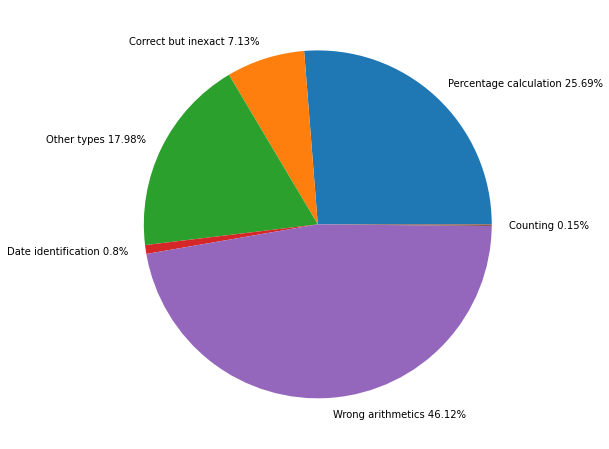

In [238]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array([count_percent, count_mostly_correct, count_others, count_date, count_arithmetic, count_counting])
mylabels = ["Percentage calculation"+percentage(count_percent, count_wrong), "Correct but inexact"+percentage(count_mostly_correct, count_wrong), "Other types"+percentage(count_others, count_wrong), "Date identification"+percentage(count_date, count_wrong), "Wrong arithmetics"+percentage(count_arithmetic, count_wrong), "Counting"+percentage(count_counting, count_wrong)]
plt.figure(figsize = (10,8))
plt.pie(y, labels = mylabels)
plt.savefig('error_analysis_pie')

# data aggregation of folds

In [ ]:
data_train = {}
for i in [1,2,3,4]:
    fname = 'fold-' + str(i)
    f = open(fname)
    data_f = json.load(f)
    data_train.update(data_f)

In [ ]:
data_test = {}
fname = 'fold-0'
f = open(fname)
data_f = json.load(f)
data_test.update(data_f)

In [ ]:
with open('drop_dataset_train_5.json', 'w') as outfile:
    json.dump(data_train, outfile)

In [ ]:
with open('drop_dataset_test_5.json', 'w') as outf:
    json.dump(data_test, outf)